In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb

## NOTE: this model is gonna be slightly better, but suspiscious with non-rolling window of data


# reading dat
dat = pd.read_csv("MLDataSplit/combined.csv")

# modifying dat to remove character values
dat["WinAsInt"] = dat["Win"].transform(lambda x: int(x == "WIN"))
dat = dat.drop(axis = 1, labels = "Win")
print(dat.shape)

(732, 77)


In [26]:
correlations = dat.corr()["WinAsInt"].sort_values(ascending = False)

print(correlations["SUP_Deaths"])

0.039035847903507184


In [27]:
print(correlations[correlations < -0.03])
print()
print(correlations[correlations > 0.12])

BOT_VSPM     -0.031457
JNG_Deaths   -0.039680
TOP_Deaths   -0.078740
BOT_Deaths   -0.110771
Name: WinAsInt, dtype: float64

WinAsInt      1.000000
Kills         0.161840
WinNum        0.153980
JNG_KAPM      0.145284
Towers        0.139821
BOT_KAPM      0.133521
BOT_GPM       0.131313
MID_KAPM      0.131197
JNG_Kills     0.126467
Mid_Plates    0.124605
MID_GD15      0.122615
MID_Kills     0.122253
JNG_GPM       0.121463
BOT_XPD15     0.120295
Name: WinAsInt, dtype: float64


In [28]:
input_vars = correlations[correlations < -0.03].index.to_list() + correlations[correlations > 0.12].index.to_list()
training_dat = dat[input_vars]
# thinned out dataset actually substantially worse at predicting than the full one is
# training_dat = dat
print(training_dat)

# split test and training data
test_dat = training_dat.sample(frac = 0)
training_dat = training_dat.drop(test_dat.index)

# setting up for xgboost
training_label = training_dat["WinAsInt"]
training_dat = training_dat.drop(axis = 1, labels = "WinAsInt")
test_label = test_dat["WinAsInt"]
test_dat = test_dat.drop(axis = 1, labels = "WinAsInt")

dtrain = xgb.DMatrix(data = training_dat, label = training_label)
dtest = xgb.DMatrix(data = test_dat, label = test_label)

print(training_dat.shape)
print(test_dat.shape)

     BOT_VSPM  JNG_Deaths  TOP_Deaths  BOT_Deaths  WinAsInt      Kills  \
0         NaN    2.333333         NaN         NaN         0  13.555556   
1    1.232105    1.684211    2.210526    1.894737         1  12.736842   
2         NaN    1.947368    2.684211         NaN         0  11.684211   
3    1.503158    2.250000         NaN    2.000000         1  10.950000   
4    1.120000    2.000000    1.666667    1.941176         1  15.666667   
..        ...         ...         ...         ...       ...        ...   
727  1.203333    2.777778    2.000000    1.888889         0  14.555556   
728       NaN    3.600000    3.700000         NaN         0  17.200000   
729  1.085556    2.111111    2.333333    2.444444         1  19.888889   
730  1.557778    2.555556    2.666667    2.000000         1  11.888889   
731       NaN    3.666667    4.444444         NaN         0  14.666667   

       WinNum  JNG_KAPM    Towers  BOT_KAPM     BOT_GPM  MID_KAPM  JNG_Kills  \
0    0.722222  0.311667  7.4444

In [29]:
param = {'max_depth': 3, 'eta': 0.1, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'

num_round = 500
evallist = [(dtrain, "train"), (dtest, "test")]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.66251	test-auc:nan
[1]	train-auc:0.66620	test-auc:nan
[2]	train-auc:0.67458	test-auc:nan
[3]	train-auc:0.68192	test-auc:nan
[4]	train-auc:0.68469	test-auc:nan
[5]	train-auc:0.68558	test-auc:nan
[6]	train-auc:0.68639	test-auc:nan
[7]	train-auc:0.68795	test-auc:nan
[8]	train-auc:0.69182	test-auc:nan
[9]	train-auc:0.69406	test-auc:nan
[10]	train-auc:0.69527	test-auc:nan
[11]	train-auc:0.69753	test-auc:nan
[12]	train-auc:0.69771	test-auc:nan
[13]	train-auc:0.69919	test-auc:nan
[14]	train-auc:0.69992	test-auc:nan
[15]	train-auc:0.70059	test-auc:nan
[16]	train-auc:0.70113	test-auc:nan
[17]	train-auc:0.70207	test-auc:nan
[18]	train-auc:0.70301	test-auc:nan
[19]	train-auc:0.70362	test-auc:nan
[20]	train-auc:0.70453	test-auc:nan
[21]	train-auc:0.70407	test-auc:nan
[22]	train-auc:0.70518	test-auc:nan
[23]	train-auc:0.70575	test-auc:nan
[24]	train-auc:0.70627	test-auc:nan
[25]	train-auc:0.70669	test-auc:nan
[26]	train-auc:0.70766	test-auc:nan
[27]	train-auc:0.70784	test-auc:nan
[2

c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[55]	train-auc:0.71424	test-auc:nan
[56]	train-auc:0.71434	test-auc:nan
[57]	train-auc:0.71436	test-auc:nan
[58]	train-auc:0.71436	test-auc:nan
[59]	train-auc:0.71437	test-auc:nan
[60]	train-auc:0.71519	test-auc:nan
[61]	train-auc:0.71532	test-auc:nan
[62]	train-auc:0.71526	test-auc:nan
[63]	train-auc:0.71533	test-auc:nan
[64]	train-auc:0.71533	test-auc:nan
[65]	train-auc:0.71528	test-auc:nan
[66]	train-auc:0.71548	test-auc:nan
[67]	train-auc:0.71570	test-auc:nan
[68]	train-auc:0.71572	test-auc:nan
[69]	train-auc:0.71590	test-auc:nan
[70]	train-auc:0.71605	test-auc:nan
[71]	train-auc:0.71621	test-auc:nan
[72]	train-auc:0.71622	test-auc:nan
[73]	train-auc:0.71645	test-auc:nan
[74]	train-auc:0.71663	test-auc:nan
[75]	train-auc:0.71672	test-auc:nan
[76]	train-auc:0.71696	test-auc:nan
[77]	train-auc:0.71700	test-auc:nan
[78]	train-auc:0.71704	test-auc:nan
[79]	train-auc:0.71724	test-auc:nan
[80]	train-auc:0.71724	test-auc:nan
[81]	train-auc:0.71768	test-auc:nan
[82]	train-auc:0.71790	test-

c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

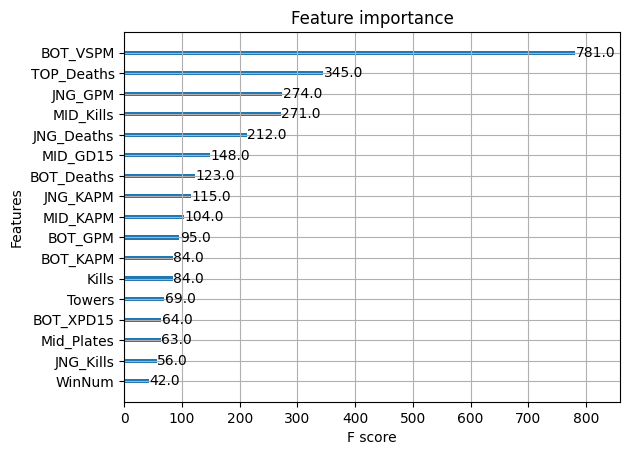

In [30]:
xgb.plot_importance(bst)

In [31]:
prediction_data = pd.read_csv("MLDataSplit/LEC_2023_Spring_Test.csv")
teams = prediction_data["Team"].to_frame()
prediction_data = prediction_data.drop(axis = 1, labels = ["Team"])
input_vars.remove("WinAsInt")

prediction_data = prediction_data[input_vars]

dpred = xgb.DMatrix(prediction_data)

scores = bst.predict(dpred)
teams["Small Model Scores"] = scores

print(teams)

             Team  Small Model Scores
0   Team Vitality            0.323036
1   Team Heretics            0.250136
2          Fnatic            0.541104
3           Rogue            0.315794
4        Team BDS            0.561700
5      G2 Esports            0.608241
6    Karmine Corp            0.612833
7          GIANTX            0.417682
8   MAD Lions KOI            0.615396
9       SK Gaming            0.471833
10  Team Vitality            0.323036
11       Team BDS            0.561700
12  Team Heretics            0.250136
13          Rogue            0.315794
14         Fnatic            0.541104
15   Karmine Corp            0.612833
16         GIANTX            0.417682
17      SK Gaming            0.471833
18  MAD Lions KOI            0.615396
19     G2 Esports            0.608241
20          Rogue            0.315794
21       Team BDS            0.561700
22      SK Gaming            0.471833
23  Team Vitality            0.323036
24         GIANTX            0.417682
25  MAD Lion

In [32]:
input_vars = dat.columns.to_list()
training_dat = dat[input_vars]
# thinned out dataset actually substantially worse at predicting than the full one is
# training_dat = dat
# print(training_dat)

# split test and training data
test_dat = training_dat.sample(frac = 0)
training_dat = training_dat.drop(test_dat.index)

# setting up for xgboost
training_label = training_dat["WinAsInt"]
training_dat = training_dat.drop(axis = 1, labels = "WinAsInt")
test_label = test_dat["WinAsInt"]
test_dat = test_dat.drop(axis = 1, labels = "WinAsInt")

dtrain = xgb.DMatrix(data = training_dat, label = training_label)
dtest = xgb.DMatrix(data = test_dat, label = test_label)

print(training_dat.shape)
print(test_dat.shape)

(732, 76)
(0, 76)


In [33]:
param = {'max_depth': 3, 'eta': 0.1, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'

num_round = 500
evallist = [(dtrain, "train"), (dtest, "test")]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.67760	test-auc:nan
[1]	train-auc:0.68659	test-auc:nan
[2]	train-auc:0.68647	test-auc:nan
[3]	train-auc:0.69245	test-auc:nan
[4]	train-auc:0.69483	test-auc:nan
[5]	train-auc:0.69637	test-auc:nan
[6]	train-auc:0.69951	test-auc:nan
[7]	train-auc:0.70129	test-auc:nan
[8]	train-auc:0.70276	test-auc:nan
[9]	train-auc:0.70201	test-auc:nan
[10]	train-auc:0.70276	test-auc:nan
[11]	train-auc:0.70366	test-auc:nan
[12]	train-auc:0.70423	test-auc:nan
[13]	train-auc:0.70449	test-auc:nan
[14]	train-auc:0.70529	test-auc:nan
[15]	train-auc:0.70638	test-auc:nan
[16]	train-auc:0.70732	test-auc:nan
[17]	train-auc:0.70762	test-auc:nan
[18]	train-auc:0.70837	test-auc:nan
[19]	train-auc:0.70871	test-auc:nan
[20]	train-auc:0.70890	test-auc:nan
[21]	train-auc:0.70941	test-auc:nan
[22]	train-auc:0.70957	test-auc:nan
[23]	train-auc:0.70968	test-auc:nan
[24]	train-auc:0.70998	test-auc:nan
[25]	train-auc:0.71019	test-auc:nan
[26]	train-auc:0.71027	test-auc:nan
[27]	train-auc:0.71059	test-auc:nan
[2

c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[47]	train-auc:0.71391	test-auc:nan
[48]	train-auc:0.71394	test-auc:nan
[49]	train-auc:0.71426	test-auc:nan
[50]	train-auc:0.71469	test-auc:nan
[51]	train-auc:0.71495	test-auc:nan
[52]	train-auc:0.71517	test-auc:nan
[53]	train-auc:0.71529	test-auc:nan
[54]	train-auc:0.71544	test-auc:nan
[55]	train-auc:0.71553	test-auc:nan
[56]	train-auc:0.71586	test-auc:nan
[57]	train-auc:0.71634	test-auc:nan
[58]	train-auc:0.71635	test-auc:nan
[59]	train-auc:0.71648	test-auc:nan
[60]	train-auc:0.71664	test-auc:nan
[61]	train-auc:0.71686	test-auc:nan
[62]	train-auc:0.71723	test-auc:nan
[63]	train-auc:0.71761	test-auc:nan
[64]	train-auc:0.71756	test-auc:nan
[65]	train-auc:0.71782	test-auc:nan
[66]	train-auc:0.71794	test-auc:nan
[67]	train-auc:0.71789	test-auc:nan
[68]	train-auc:0.71847	test-auc:nan
[69]	train-auc:0.71858	test-auc:nan
[70]	train-auc:0.71874	test-auc:nan
[71]	train-auc:0.71902	test-auc:nan
[72]	train-auc:0.71912	test-auc:nan
[73]	train-auc:0.71918	test-auc:nan
[74]	train-auc:0.71960	test-

c:\Users\carte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[305]	train-auc:0.72397	test-auc:nan
[306]	train-auc:0.72397	test-auc:nan
[307]	train-auc:0.72398	test-auc:nan
[308]	train-auc:0.72400	test-auc:nan
[309]	train-auc:0.72400	test-auc:nan
[310]	train-auc:0.72400	test-auc:nan
[311]	train-auc:0.72401	test-auc:nan
[312]	train-auc:0.72400	test-auc:nan
[313]	train-auc:0.72400	test-auc:nan
[314]	train-auc:0.72400	test-auc:nan
[315]	train-auc:0.72400	test-auc:nan
[316]	train-auc:0.72401	test-auc:nan
[317]	train-auc:0.72401	test-auc:nan
[318]	train-auc:0.72401	test-auc:nan
[319]	train-auc:0.72401	test-auc:nan
[320]	train-auc:0.72401	test-auc:nan
[321]	train-auc:0.72401	test-auc:nan
[322]	train-auc:0.72401	test-auc:nan
[323]	train-auc:0.72401	test-auc:nan
[324]	train-auc:0.72400	test-auc:nan
[325]	train-auc:0.72400	test-auc:nan
[326]	train-auc:0.72400	test-auc:nan
[327]	train-auc:0.72400	test-auc:nan
[328]	train-auc:0.72401	test-auc:nan
[329]	train-auc:0.72403	test-auc:nan
[330]	train-auc:0.72403	test-auc:nan
[331]	train-auc:0.72403	test-auc:nan
[

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

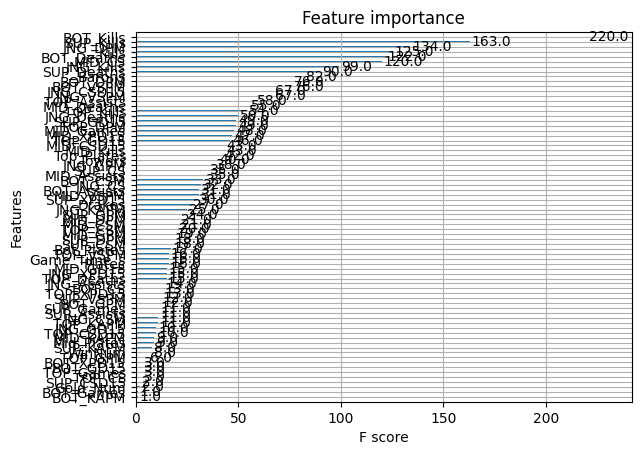

In [34]:
xgb.plot_importance(bst)

In [35]:
prediction_data = pd.read_csv("MLDataSplit/LEC_2023_Spring_Test.csv")
# teams = prediction_data["Team"].to_frame()
prediction_data = prediction_data.drop(axis = 1, labels = ["Team"])
input_vars.remove("WinAsInt")

prediction_data = prediction_data[input_vars]

dpred = xgb.DMatrix(prediction_data)

scores = bst.predict(dpred)
teams["Full Model Scores"] = scores

print(teams)

             Team  Small Model Scores  Full Model Scores
0   Team Vitality            0.323036           0.493551
1   Team Heretics            0.250136           0.272887
2          Fnatic            0.541104           0.577609
3           Rogue            0.315794           0.456404
4        Team BDS            0.561700           0.713458
5      G2 Esports            0.608241           0.678846
6    Karmine Corp            0.612833           0.582520
7          GIANTX            0.417682           0.288641
8   MAD Lions KOI            0.615396           0.539008
9       SK Gaming            0.471833           0.467600
10  Team Vitality            0.323036           0.493551
11       Team BDS            0.561700           0.713458
12  Team Heretics            0.250136           0.272887
13          Rogue            0.315794           0.456404
14         Fnatic            0.541104           0.577609
15   Karmine Corp            0.612833           0.582520
16         GIANTX            0.

In [36]:
matchups = pd.DataFrame()

for i in range(30):
    blue_dat = teams.loc[i * 2]
    red_dat = teams.loc[i * 2 + 1]
    blue_team = blue_dat["Team"]
    red_team = red_dat["Team"]

    # skew a little to blue side win rate
    scores = blue_dat.drop("Team") - red_dat.drop("Team") > -0.02
    newrow = pd.Series([blue_team, red_team, int(scores[0]), int(scores[1])])

    newrow = newrow.to_frame().transpose()
    matchups = pd.concat([matchups, newrow], axis = 0)
    
matchups.columns = ["B_Team", "R_Team", "Small Model", "Full Model"]
print(matchups)

    
matchups.to_csv("predictions/splitModel.csv")    

    


          B_Team         R_Team Small Model Full Model
0  Team Vitality  Team Heretics           1          1
0         Fnatic          Rogue           1          1
0       Team BDS     G2 Esports           0          1
0   Karmine Corp         GIANTX           1          1
0  MAD Lions KOI      SK Gaming           1          1
0  Team Vitality       Team BDS           0          0
0  Team Heretics          Rogue           0          0
0         Fnatic   Karmine Corp           0          1
0         GIANTX      SK Gaming           0          0
0  MAD Lions KOI     G2 Esports           1          0
0          Rogue       Team BDS           0          0
0      SK Gaming  Team Vitality           1          0
0         GIANTX  MAD Lions KOI           0          0
0  Team Heretics         Fnatic           0          0
0     G2 Esports   Karmine Corp           1          1
0      SK Gaming       Team BDS           0          0
0         GIANTX         Fnatic           0          0
0     G2 E